In [1]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice
from sklearn import preprocessing

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

import scipy
from sklearn.linear_model import LinearRegression

from finance.utilities import utils
from finance.data_science.utilities import (financial_utils, time_series_utils, 
                                            cluster_utils, random_forest_utils, nn_utils)

### Get stock data

In [2]:
query = f"""
    with 
    tickers as (
    select distinct 
        ticker
        , sector
        , industry
    from nasdaq.listed_stocks
    where ticker in ('AEE' , 'WEC')
    limit 100
    )
    select 
        market_datetime
        , extract(year from market_datetime) as _year
        , extract(month from market_datetime) as month_of_year
        , extract(week from market_datetime) as week_of_year
        , symbol
        , sector
        , industry
        , open
        , high
        , low
        , close
        , volume
    from td.equities as equities
    inner join tickers
        on tickers.ticker = equities.symbol
    where market_datetime between '2019-01-09' and '2019-09-09'
    """

df = utils.query_db(query=query)
df.head()

,market_datetime,_year,month_of_year,week_of_year,symbol,sector,industry,open,high,low,close,volume
0,2019-01-09 06:00:00,2019.0,1.0,2.0,AEE,Public Utilities,Power Generation,64.64,65.03,64.100,64.38,1501042.0
1,2019-01-10 06:00:00,2019.0,1.0,2.0,AEE,Public Utilities,Power Generation,64.53,65.86,64.270,65.81,1080052.0
2,2019-01-11 06:00:00,2019.0,1.0,2.0,AEE,Public Utilities,Power Generation,65.71,65.89,65.085,65.55,873670.0
3,2019-01-14 06:00:00,2019.0,1.0,3.0,AEE,Public Utilities,Power Generation,64.87,65.15,64.170,64.96,1499480.0
4,2019-01-15 06:00:00,2019.0,1.0,3.0,AEE,Public Utilities,Power Generation,64.77,66.66,64.670,66.04,1794932.0


### Clean data

In [3]:
df['market_datetime_month'] = df['market_datetime'].dt.month
df['market_datetime_day_of_week'] = df['market_datetime'].dt.dayofweek

df['market_datetime_int'] = df['market_datetime'].astype(int)

df = cluster_utils.encode_one_hot(df, ['symbol', 'sector', 'industry', 
                                       'market_datetime_month', 'market_datetime_day_of_week'])

In [4]:
df_symbol = df.groupby(['symbol', 'market_datetime']).mean()

one = df_symbol[df_symbol.index.get_level_values('symbol').isin([df['symbol'].unique()[0]])].open
two = df_symbol[df_symbol.index.get_level_values('symbol').isin([df['symbol'].unique()[1]])].open

one = one.head(min(len(one), len(two)))
two = two.head(min(len(one), len(two)))

In [5]:
print('Correlation: ' + str(scipy.stats.pearsonr(one, two)[0]))

Correlation: 0.9103280910596043


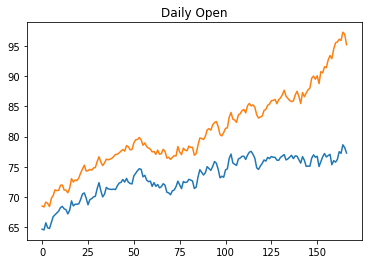

In [6]:
plt.title('Daily Open')
plt.plot(one.values)
plt.plot(two.values)
plt.show()

In [7]:
regression = LinearRegression()
regression.fit(X=one.values.reshape(-1, 1), y=two.values.reshape(-1, 1))

prediction = regression.predict(one.values.reshape(-1, 1))

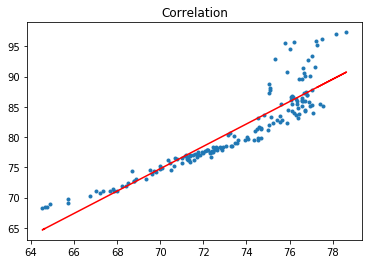

In [8]:
plt.title('Correlation')
plt.scatter(one, two, marker='.')
plt.plot(one, prediction, color='r')
plt.show()

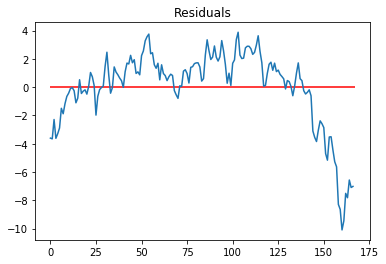

In [9]:
residuals = prediction - two.values.reshape(-1, 1)
plt.title('Residuals')
plt.hlines(0, xmin=0, xmax=len(residuals), color='r')
plt.plot(residuals)
plt.show()

In [ ]:
"""with tickers as (
	select distinct 
		ticker
		, sector
		, industry
	from nasdaq.listed_stocks
	limit 1000)
, raw as (
	select symbol
		, market_datetime
		, open
		, sector
		, industry
	from td.equities as e
	inner join tickers as l
		on e.symbol = l.ticker
	where market_datetime > '2018-01-09')
sectors as (
	select a.market_datetime as a_market_datetime
		, a.symbol as a_symbol
		, b.symbol as b_symbol
		, a.open as a_open
		, b.open as b_open
	from raw as a
	inner join raw as b
		on a.symbol <> b.symbol
		and a.market_datetime = b.market_datetime
		and a.sector = b.sector
		and a.industry = b.industry
	where a.market_datetime between '2019-01-09' and '2019-01-15'
)"""